In [7]:
import pandas as pd
import nltk

In [24]:
df = pd.read_csv('openreg_dataset.csv')
print(df.head())

print(df.shape)

                                                 URL  \
0  http://cnn.com/2017/07/06/health/sri-lanka-den...   
1  http://www.cnn.com/2017/07/10/opinions/trump-n...   
2  http://www.reuters.com/article/us-usa-trump-ru...   
3  https://www.bloomberg.com/news/articles/2017-0...   
4  http://cnn.com/news/economy/your-money-your-am...   

                                               TITLE  \
0  DEADLY DENGUE FEVER OUTBREAK KILLS HUNDREDS IN...   
1             WHY TRUMP WILL NEVER BE A GREAT LEADER   
2  PR SPECIALIST SAYS SET UP MEETING BETWEEN TRUM...   
3                                            Missing   
4                           YOUR MONEY, YOUR AMERICA   

                                                TEXT  
0  Story highlights More than 77,000 infections h...  
1  Doug Elmets owns Elmets Communications, a Sacr...  
2  (Reuters) - The public relations specialist wh...  
3  For Fed Pacheco, it was a long journey from mo...  
4                                                Na

In [46]:
df = df.dropna()
print()

print(df.isnull().any())



URL      False
TITLE    False
TEXT     False
dtype: bool


In [87]:
help(nltk.sent_tokenize)

Help on function sent_tokenize in module nltk.tokenize:

sent_tokenize(text, language='english')
    Return a sentence-tokenized copy of *text*,
    using NLTK's recommended sentence tokenizer
    (currently :class:`.PunktSentenceTokenizer`
    for the specified language).
    
    :param text: text to split into sentences
    :param language: the model name in the Punkt corpus



In [122]:
for text in texts:
    if ' u ' in text:
        print(text)
        break

Nelsan Ellis, the actor who lit up the screen on HBO's vampire drama "True Blood," has died at age 39.

The cause of death was complications from heart failure, his manager, Emily Gerson Saines, told CNN.

Ellis had roles in several movies during his career, including "Get on Up," "Lee Daniels' The Butler" and "The Help." But he was best known for his performance on "True Blood" as Lafayette, a cook and medium whose tell-it-like-it-is attitude made him a favorite among the television show's fans.

HBO said in a statement Saturday that it was "extremely saddened" to hear of his passing.

"Nelsan was a long-time member of the HBO family whose groundbreaking portrayal of Lafayette will be remembered fondly within the overall legacy of True Blood. Nelsan will be dearly missed by his fans and all of us at HBO," the statement read. HBO, like CNN, is owned by Time Warner.

"True Blood" creator Alan Ball added: "Nelsan was a singular talent whose creativity never ceased to amaze me. Working wi

In [123]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
# load nltk's SnowballStemmer as variabled 'stemmer'
#from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

#stemmer = SnowballStemmer("english")
stemmer = PorterStemmer()

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    review = re.sub('[^a-zA-z]', ' ', text)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in stopwords.words("english") + ['u']]
    return review
    
    '''
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[^a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    
    return stems
    '''
    

def tokenize_only(text):
    
    review = re.sub('[^a-zA-z]', ' ', text)
    review = review.lower().split()
    review = [word for word in review if not word in stopwords.words("english") + ['u']]
    return review
    
    '''
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[^a-zA-Z]', token):
            filtered_tokens.append(token)
    
    return filtered_tokens
    '''
    

In [124]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
import re

titles = df['TITLE'].values
texts = df['TEXT'].values

totalvocab_stemmed = []
totalvocab_tokenized = []
for index, i in enumerate(texts):
    try:
        allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
        totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)
    except:
        raise
        print(index, i)
        break

In [125]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 206256 items in vocab_frame


In [126]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, max_features=210000,
                                   min_df=0.15, stop_words='english',
                                   use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 54.6 s, sys: 8.27 s, total: 1min 2s
Wall time: 1min 3s
(579, 1008)


In [127]:
terms = tfidf_vectorizer.get_feature_names()

In [128]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print()

In [153]:
from sklearn.cluster import KMeans

num_clusters = 480
km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 21.2 s, sys: 474 ms, total: 21.7 s
Wall time: 22.9 s


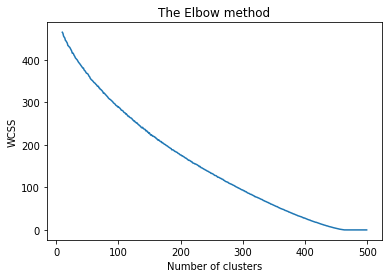

In [151]:
wcss = []

for i in range(10, 500):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(tfidf_matrix)
    
    wcss.append(kmeans.inertia_)

plt.plot(range(10, 500), wcss)
plt.title('The Elbow method')    
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [140]:
films = { 'title': titles, 'synopsis': texts, 'cluster': clusters}
frame = pd.DataFrame(films, index = [clusters] , columns = ['title', 'cluster', 'genre'])
frame['cluster'].value_counts()
print()

In [141]:
frame.head()

,title,cluster,genre
36,DEADLY DENGUE FEVER OUTBREAK KILLS HUNDREDS IN...,36,NaN
3,WHY TRUMP WILL NEVER BE A GREAT LEADER,3,NaN
10,PR SPECIALIST SAYS SET UP MEETING BETWEEN TRUM...,10,NaN
71,Missing,71,NaN
4,"FRESH VIOLENCE HITS INDIA'S DARJEELING HILLS, ...",4,NaN


In [154]:
print(frame[frame['cluster'] == 3])

                                               title  cluster genre
3             WHY TRUMP WILL NEVER BE A GREAT LEADER        3   NaN
3      TRUMP'S 'CYBER SECURITY UNIT' PLAN WITH PUTIN        3   NaN
3            PUTIN SET A TRAP AND TRUMP FELL INTO IT        3   NaN
3                 PRESIDENT STEPHEN COLBERT IN 2020?        3   NaN
3             WHY TRUMP WILL NEVER BE A GREAT LEADER        3   NaN
3  TRUMP AND PENA NIETO DONT DISCUSS WHO WILL PA...        3   NaN
3            PUTIN SET A TRAP AND TRUMP FELL INTO IT        3   NaN
3        A GREAT DAY FOR PUTIN, A GOOD ONE FOR TRUMP        3   NaN
3  SANDERS CONTRADICTS TRUMP ON WHETHER SANCTIONS...        3   NaN
3  PUTIN SAYS TRUMP WAS 'SATISFIED' WITH HIS ELEC...        3   NaN
3  TRUMP OFFICIALS DECLINE TO REBUT RUSSIA'S CLAI...        3   NaN
3   AFTER THE G20, THE US MAY BECOME A GLOBAL PARIAH        3   NaN
3  DEM AMENDMENT WOULD BLOCK TRUMP-PUTIN CYBER EF...        3   NaN
3                    DON'T FALL FOR THE 'FAKE TR

In [155]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
print()

Top terms per cluster:

Cluster 0 words: b'consumers', b'reports', b'said', b'caused', b'case', b'eat', b'game', b'risk', b'tests', b'according',

Cluster 1 words: b'trump', b'photos', b'rising', b'donald', b'donald', b'new', b'york', b'republican', b'health', b'new',

Cluster 2 words: b'percent', b'rose', b'dollars', b'stock', b'market', b'week', b'data', b'equity', b'fell', b'point',

Cluster 3 words: b'syria', b'russia', b'establishment', b'agreement', b'borders', b'syrian', b'force', b'said', b'tillerson', b'russian',

Cluster 4 words: b'facebook', b'happened', b'world', b'young', b'favorable', b'familiar', b'far', b'father', b'fears', b'falling',

Cluster 5 words: b'family', b'live', b'people', b'room', b'home', b'said', b'help', b'life', b'hotels', b'wife',

Cluster 6 words: b'protests', b'police', b'hamburg', b'g', b'group', b'friday', b'anti', b'red', b'summit', b'waters',

Cluster 7 words: b'source', b'point', b'percent', b'shared', b'stake', b'planned', b'funding', b'company'

In [156]:
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

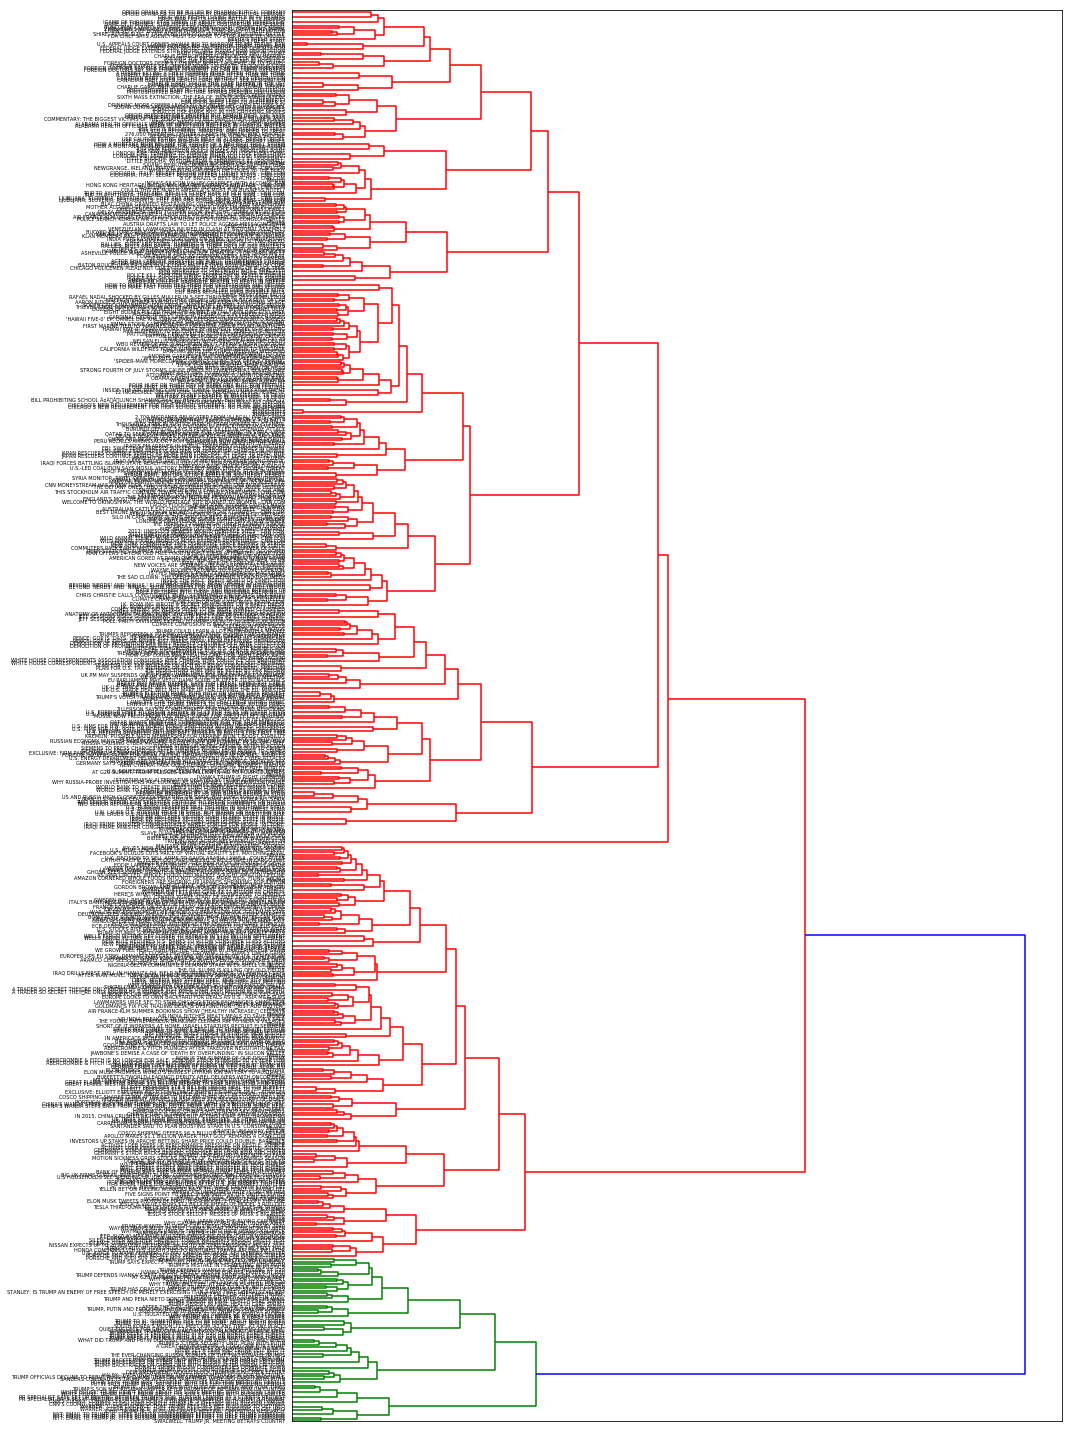

In [144]:
plt.show()

In [152]:
# http://brandonrose.org/clustering